In [36]:
%%configure -f 
{"executorMemory": "12G", "executorCores": 6}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
5,None,pyspark,idle,,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
5,None,pyspark,idle,,,None,✔


In [37]:
from typing import List

from pyspark import SparkFiles
from subprocess import call
import sys


def install_deps(deps: List[str]) -> None:
    call([sys.executable, '-m', 'pip', 'install', '-q', '-t', SparkFiles.getRootDirectory(), *deps])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
install_deps(['numpy', 'matplotlib', 'pandas', 'scipy'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
distance_calculation_df = (
    spark
    .read
    .format("mongodb")
    .option("database", "enhancer3d")
    .option("collection", "distance_calculation")
    .load()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
distance_calculation_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

28618225

In [25]:
from pyspark.sql import functions as F, types as T
import numpy as np

@F.udf(T.ArrayType(T.DoubleType()))
def diff(A, B):
    return np.abs(np.array(A) - np.array(B)).tolist()

@F.udf(T.DoubleType())
def var(A):
    return float(np.var(A))

@F.udf(T.DoubleType())
def avg(A):
    return float(np.mean(A))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
results_GM12878_Deni_chr1_74280_3521135_df = (
    distance_calculation_df
    .select('_id.*', '*')
    .drop('_id')
    .where("project_id == 'GM12878_demo_project' and ensemble_id == 'results_GM12878_Deni_chr1_74280_3521135'")
    .alias("ref")
)

results_GM12878_Deni_mod_chr1_74280_3521135_df = (
    distance_calculation_df
    .select('_id.*', '*')
    .drop('_id')
    .where("project_id == 'GM12878_demo_project' and ensemble_id == 'results_GM12878_Deni_mod_chr1_74280_3521135'")
    .alias("mod")
)

results_GM12878_Deni_chr1_74280_3521135_joined_with_mod_df = (
    results_GM12878_Deni_chr1_74280_3521135_df
    .join(
        results_GM12878_Deni_mod_chr1_74280_3521135_df,
        on=['gene_id', 'enh_id'],
        how='inner'
    )
    .select(
        'gene_id', 
        'enh_id',

        F.col('ref.enh_score').alias('enh_score'),
        
        F.col('ref.dist').alias('ref_dist'),
        F.col('ref.avg_dist').alias('ref_dist_avg'),
        var(F.col('ref.dist')).alias('ref_dist_var'),

        F.col('mod.dist').alias('mod_dist'),
        F.col('mod.avg_dist').alias('mod_dist_avg'),
        var(F.col('mod.dist')).alias('mod_dist_var'),
        
        diff(F.col('ref.dist'), F.col('mod.dist')).alias('dist_diff'),
        avg(F.col('dist_diff')).alias('dist_diff_avg'),
        var(F.col('dist_diff')).alias('dist_diff_var')
    )
)

results_GM12878_Deni_chr1_74280_3521135_joined_with_mod_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13099

In [27]:
results_pandas = results_GM12878_Deni_chr1_74280_3521135_joined_with_mod_df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Correlation between enh_score and dist_diff_avg
pearson_avg, p_avg = pearsonr(results_pandas['enh_score'], results_pandas['dist_diff_avg'])
ax1.scatter(results_pandas['enh_score'], results_pandas['dist_diff_avg'], alpha=0.6)
z = np.polyfit(results_pandas['enh_score'], results_pandas['dist_diff_avg'], 1)
p = np.poly1d(z)
ax1.plot(results_pandas['enh_score'], p(results_pandas['enh_score']), "r--")
ax1.set_title(f'Enhancer Score vs Avg Distance Difference\nr = {pearson_avg:.3f} (p = {p_avg:.3e})')
ax1.set_xlabel('Enhancer Score')
ax1.set_ylabel('Average Distance Difference')
ax1.grid(True, alpha=0.3)

# 2. Correlation between enh_score and dist_diff_var
pearson_var, p_var = pearsonr(results_pandas['enh_score'], results_pandas['dist_diff_var'])
ax2.scatter(results_pandas['enh_score'], results_pandas['dist_diff_var'], alpha=0.6)
z = np.polyfit(results_pandas['enh_score'], results_pandas['dist_diff_var'], 1)
p = np.poly1d(z)
ax2.plot(results_pandas['enh_score'], p(results_pandas['enh_score']), "r--")
ax2.set_title(f'Enhancer Score vs Distance Difference Variance\nr = {pearson_var:.3f} (p = {p_var:.3e})')
ax2.set_xlabel('Enhancer Score')
ax2.set_ylabel('Distance Difference Variance')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.plot()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

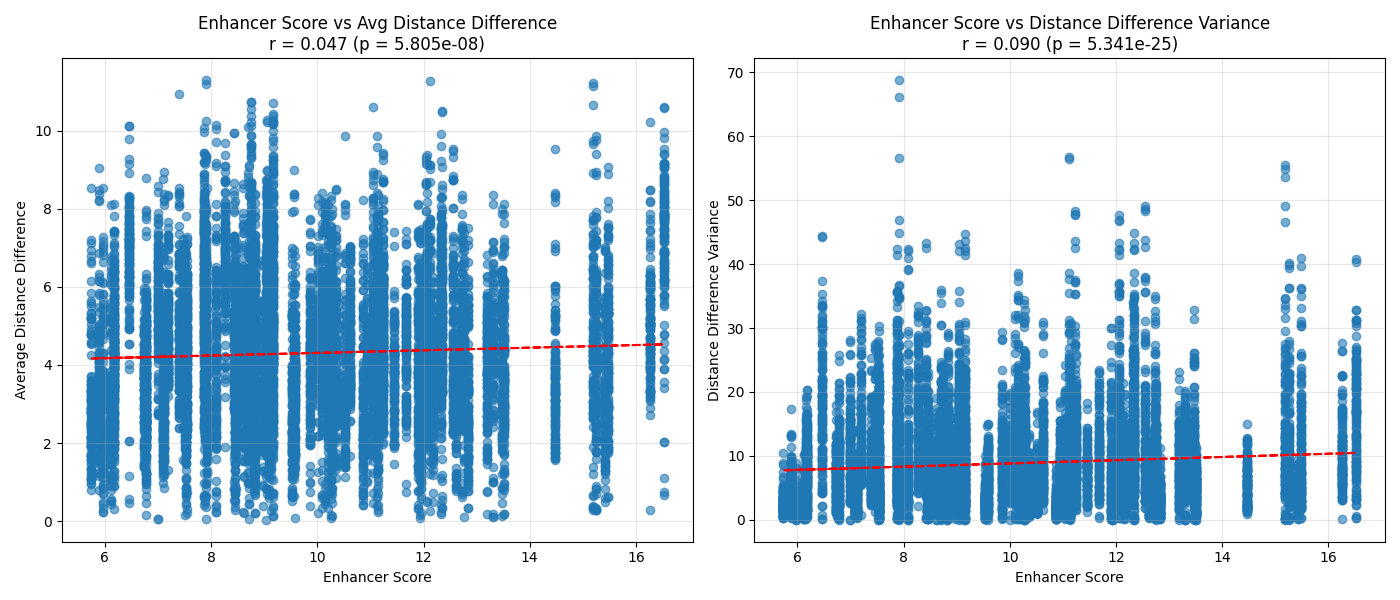

In [29]:
%matplot plt

In [30]:
# Print summary of the correlation analysis
print(f"Correlation between enhancer score and distance difference average: {pearson_avg:.3f}")
print(f"Correlation between enhancer score and distance difference variance: {pearson_var:.3f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Correlation between enhancer score and distance difference average: 0.047
Correlation between enhancer score and distance difference variance: 0.090

In [31]:
all_samples_df = (
     distance_calculation_df
    .select('_id.*', '*')
    .drop('_id')
    .where("project_id == 'GM12878_demo_project'")
    .select(
        'gene_id', 
        'enh_id',

        'enh_score',

        'dist',
        avg(F.col('dist')).alias('dist_avg'),
        var(F.col('dist')).alias('dist_var'),
    )
    .cache()
)

all_samples_pandas = all_samples_df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
len(all_samples_pandas)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

45661

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Correlation between enh_score and dist_avg
pearson_avg, p_avg = pearsonr(all_samples_pandas['enh_score'], all_samples_pandas['dist_avg'])
ax1.scatter(all_samples_pandas['enh_score'], all_samples_pandas['dist_avg'], alpha=0.6)
z = np.polyfit(all_samples_pandas['enh_score'], all_samples_pandas['dist_avg'], 1)
p = np.poly1d(z)
ax1.plot(all_samples_pandas['enh_score'], p(all_samples_pandas['enh_score']), "r--")
ax1.set_title(f'Enhancer Score vs Average Distance\nr = {pearson_avg:.3f} (p = {p_avg:.3e})')
ax1.set_xlabel('Enhancer Score')
ax1.set_ylabel('Average Distance')
ax1.grid(True, alpha=0.3)

# 2. Correlation between enh_score and dist_var
pearson_var, p_var = pearsonr(all_samples_pandas['enh_score'], all_samples_pandas['dist_var'])
ax2.scatter(all_samples_pandas['enh_score'], all_samples_pandas['dist_var'], alpha=0.6)
z = np.polyfit(all_samples_pandas['enh_score'], all_samples_pandas['dist_var'], 1)
p = np.poly1d(z)
ax2.plot(all_samples_pandas['enh_score'], p(all_samples_pandas['enh_score']), "r--")
ax2.set_title(f'Enhancer Score vs Distance Variance\nr = {pearson_var:.3f} (p = {p_var:.3e})')
ax2.set_xlabel('Enhancer Score')
ax2.set_ylabel('Distance Variance')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.plot()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

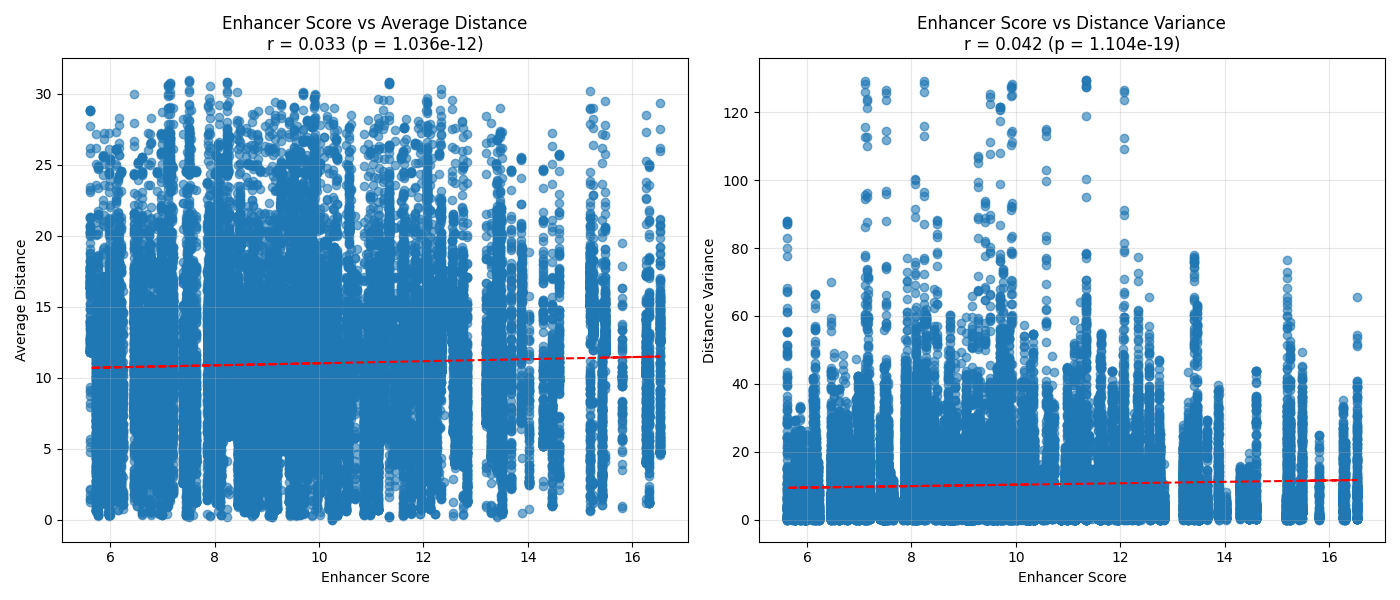

In [34]:
%matplot plt

In [35]:
# Print summary of the correlation analysis
print(f"Correlation between enhancer score and distance average: {pearson_avg:.3f}")
print(f"Correlation between enhancer score and distance variance: {pearson_var:.3f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Correlation between enhancer score and distance average: 0.033
Correlation between enhancer score and distance variance: 0.042